In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load raw data
df = pd.read_json('../data/fizzy.json', lines=True, dtype=False)

#start cleaning
df['actualCostEth'] = pd.to_numeric('0.' + df.actualCost.str.split(' ').str[0])
df['actualCostUsd'] = pd.to_numeric(df.actualCost.str.split(' ').str[2].str.slice(2,6,1))
df['blockHeight'] = pd.to_numeric(df.blockHeight)
df['gasLimit'] = pd.to_numeric(df.gasLimit)
df['gasPrice'] = pd.to_numeric('0.' + df.gasPrice.str.split(' ').str[0])
df['gasUsed'] = pd.to_numeric(df.gasUsed.str.split(' ').str[0])
df['timeStamp'] = df.timeStamp.str.extract('\((.*)\)')
df['timeStamp'] = pd.to_datetime(df.timeStamp, format='%b-%d-%Y %I:%M:%S %p +%Z')
df['inputData'] = df.inputData.str.replace('[\\r|\\n]', '')
df['functionCalled'] = df.inputData.str.extract('Function: (.*)\(')
df['flightId'] = df.inputData.str.extract('[addNewInsurance|updateFlightStatus|manualInsuranceResolution].*\[0\]:\s\s(.{64})')
df['flightNo'] = df.flightId.str.decode('hex') \
                            .str.decode('utf-8') \
                            .str.rsplit('.',n=1) \
                            .str.get(0) \
                            .str.replace('.','')
df['departureDate'] = pd.to_datetime(df.flightId.str.decode('hex') \
                                     .str.decode('utf-8') \
                                     .str.rsplit('.',n=1) \
                                     .str.get(1) \
                                     .str.slice(0,10,1), unit='s')
df['limitArrivalTime'] = df.inputData.str.extract('addNewInsurance.*\[1\]:\s\s(.{64})')
df['limitArrivalTime'] = pd.to_datetime(df.limitArrivalTime.str[-12:].apply(lambda x: None if pd.isnull(x) else int(str(x), 16)),unit='ms')
df['premium'] = df.inputData.str.extract('addNewInsurance.*\[2\]:\s\s(.{64})')
df['premium'] = df.premium.apply(lambda x: None if pd.isnull(x) else int(str(x), 16))
df['indemnity'] = df.inputData.str.extract('addNewInsurance.*\[3\]:\s\s(.{64})')
df['indemnity'] = df.indemnity.apply(lambda x: None if pd.isnull(x) else int(str(x), 16))
df['productId'] = df.inputData.str.extract('(?:addNewInsurance.*\[4\]:\s\s|manualInsuranceResolution.*\[2\]:\s\s)(.{64})')
df['actualArrivalTime'] = df.inputData.str.extract('updateFlightStatus.*\[1\]:\s\s(.{64})')
df['actualArrivalTime'] = pd.to_datetime(df.actualArrivalTime.str[-12:].apply(lambda x: None if pd.isnull(x) else int(str(x), 16)),unit='ms')
df['newStatusId'] = df.inputData.str.extract('manualInsuranceResolution.*\[1\]:\s\s(.{64})')
df['value'] = pd.to_numeric(df.value.str.slice(0,1,1))
df['eventName'] = df.eventName.str[0:-2]
df['eventStatus'] = df.eventParam5.apply(lambda x: None if x == "None" else int(str(x),16))
df['eventIndemnity'] = df[df['eventName'] == "InsuranceUpdate"]['eventParam4'].apply(lambda x: None if x == "None" else int(str(x),16))
del df['txReceiptStatus']
del df['inputData']
del df['actualCost']
del df['eventParam1']
del df['eventParam2']
del df['eventParam3']
del df['eventParam4']
del df['eventParam5']

# Informations de bases

In [3]:
# on calcul tout un tat d'indicateurs
loss = df[df['eventStatus'] == 2]['eventIndemnity'].sum()
premium = df[df['eventName'] == 'InsuranceCreation']['premium'].sum()
nbContrat = df['productId'].nunique()
nbClaim = df[df['eventStatus'] == 2]['eventIndemnity'].count()

medianPremium = df[df['eventName'] == 'InsuranceCreation']['premium'].median()
meanPremium = df[df['eventName'] == 'InsuranceCreation']['premium'].mean()
stdPremium = df[df['eventName'] == 'InsuranceCreation']['premium'].std(ddof=0)
minPremium = df[df['eventName'] == 'InsuranceCreation']['premium'].min()
maxPremium = df[df['eventName'] == 'InsuranceCreation']['premium'].max()


medianIndemnity = df[df['eventName'] == 'InsuranceCreation']['indemnity'].median()
meanIndemnity = df[df['eventName'] == 'InsuranceCreation']['indemnity'].mean()
stdIndemnity = df[df['eventName'] == 'InsuranceCreation']['indemnity'].std(ddof=0)
minIndemnity = df[df['eventName'] == 'InsuranceCreation']['indemnity'].min()
maxIndemnity = df[df['eventName'] == 'InsuranceCreation']['indemnity'].max()

blockchainCost = df['actualCostEth'].sum()

# on les affiches
print("Sinistre : " + str(loss) + "€")
print("Primes : " + str(premium) + "€")
print("S/P : " + str(round((loss/premium)*100,2)) + "%")
print("Nombre de contrat : " + str(nbContrat))
print("Nombre de sinistre : " + str(nbClaim))

print("Prime médiane : " + str(medianPremium) + "€")
print("Prime moyenne : " + str(round(meanPremium,2)) + "€")
print("Ecart type des primes : " + str(round(stdPremium,2)) + "€")
print("Prime minimum : " + str(round(minPremium,2)) + "€")
print("Prime maximum : " + str(round(maxPremium,2)) + "€")

print('Indemnité médiane : ' + str(round(medianIndemnity,2)) + '€')
print('Indemnité moyenne : ' + str(round(meanIndemnity,2)) + '€')
print('Ecart type des indemnités : ' + str(round(stdIndemnity,2)) + '€')
print('Indemnité minimum : ' + str(round(minIndemnity,2)) + '€')
print('Indemnité maximum : ' + str(round(maxIndemnity,2)) + '€')

print('Blockchain Cost : ' + str(round(blockchainCost,2)) + "$")

Sinistre : 10101.0€
Primes : 40471.0€
S/P : 24.96%
Nombre de contrat : 11405
Nombre de sinistre : 96
Prime médiane : 3.0€
Prime moyenne : 3.55€
Ecart type des primes : 1.39€
Prime minimum : 2.0€
Prime maximum : 36.0€
Indemnité médiane : 100.0€
Indemnité moyenne : 102.07€
Ecart type des indemnités : 24.52€
Indemnité minimum : 50.0€
Indemnité maximum : 500.0€
Blockchain Cost : 7.18$


# Souscriptions au cour du temps

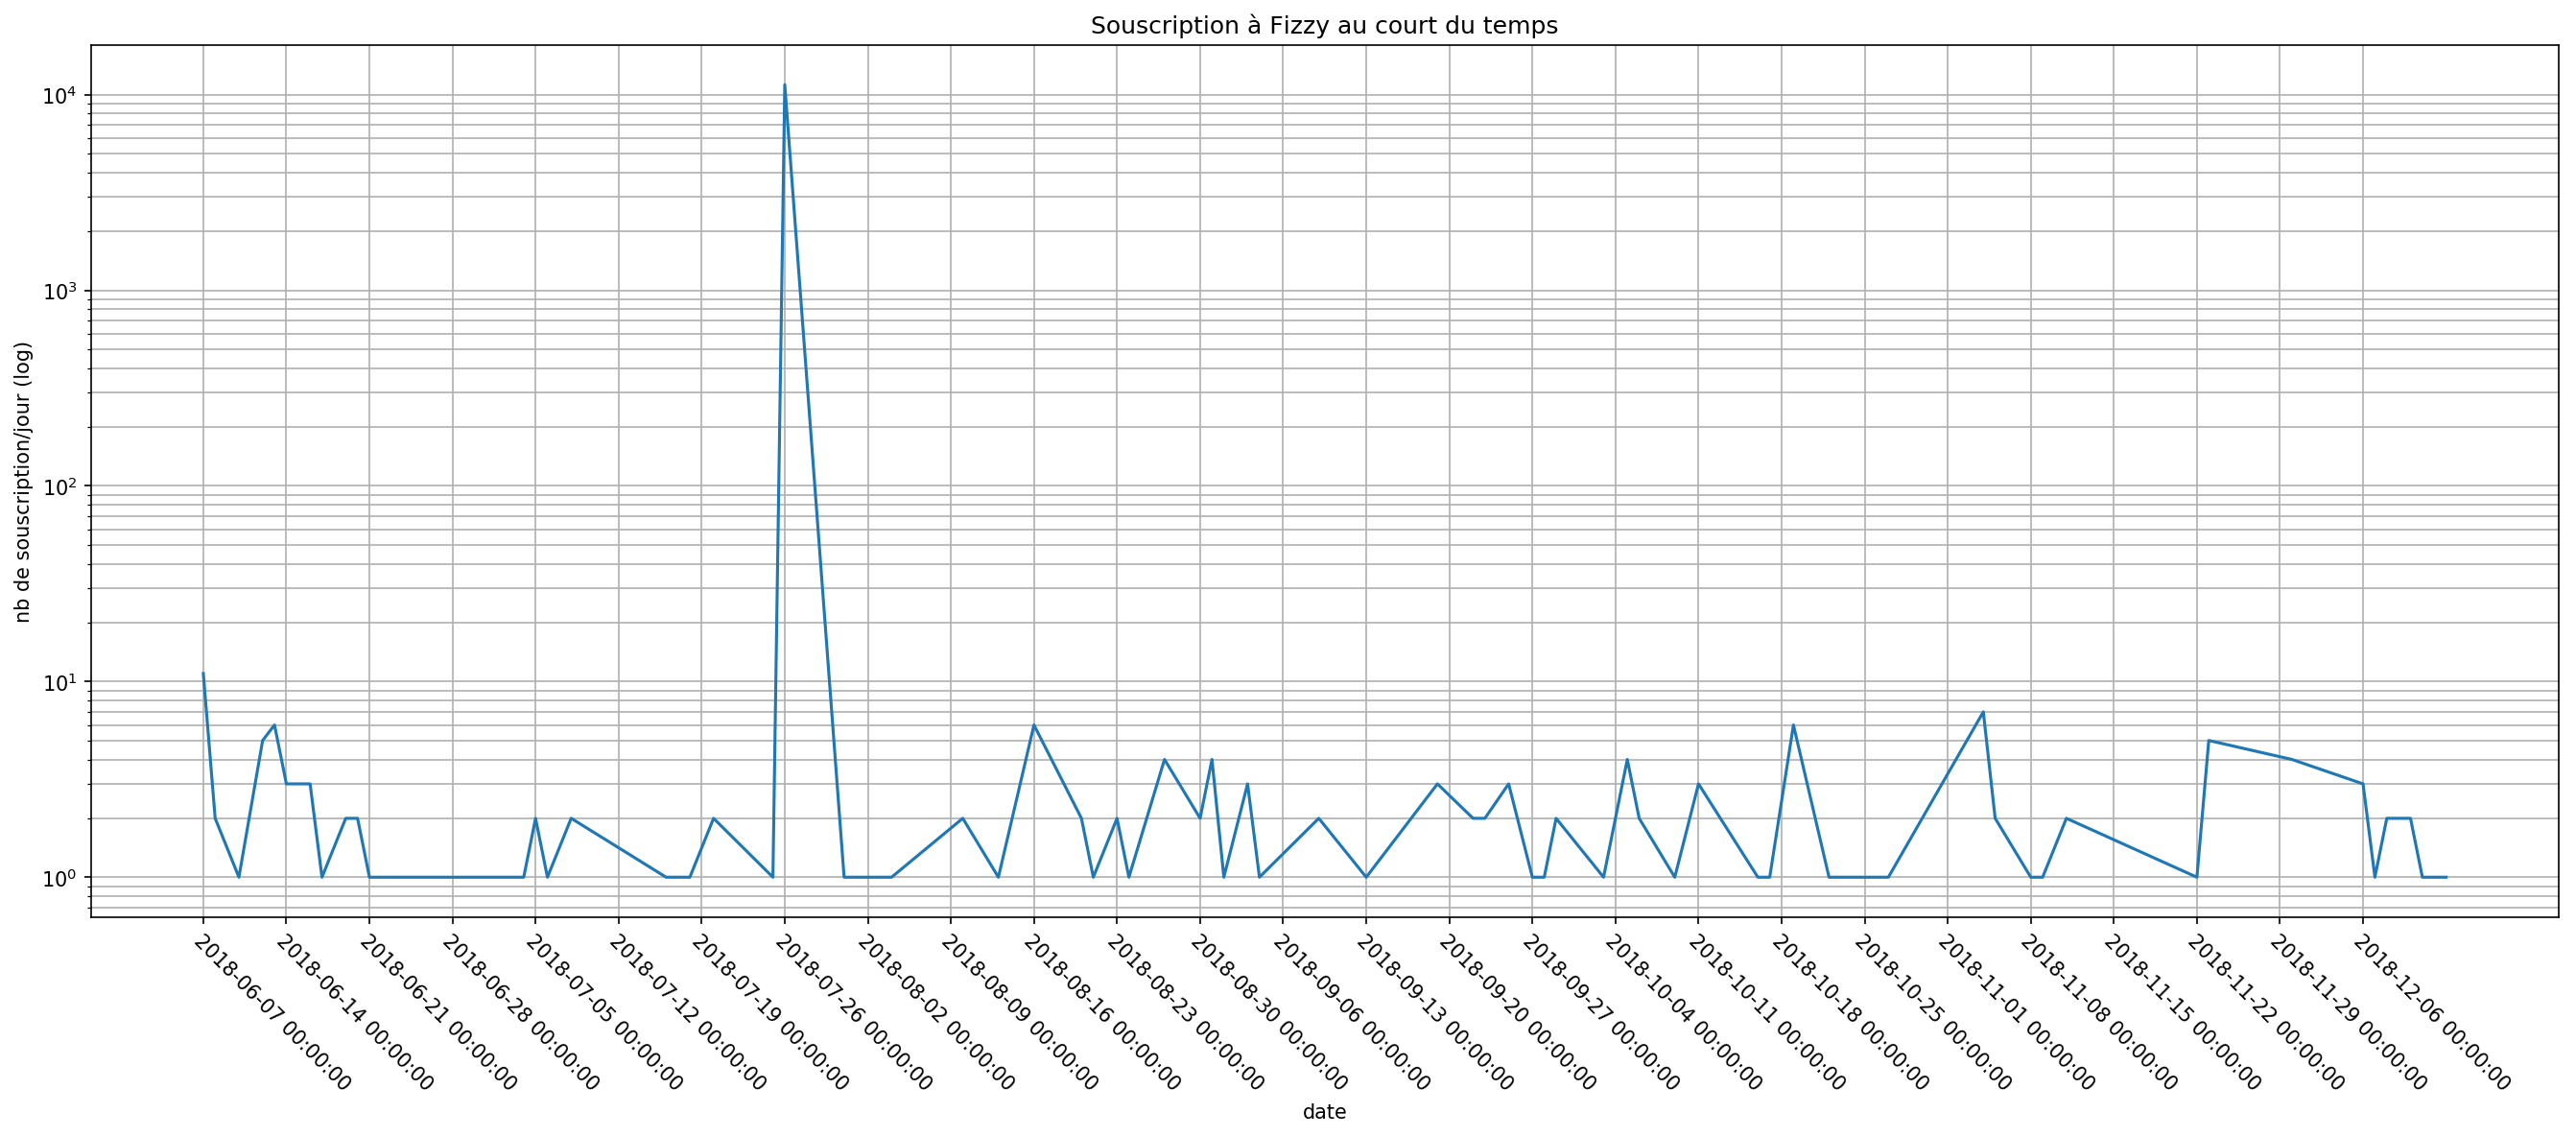

In [4]:
from datetime import datetime, timedelta

plt.figure(num=None, figsize=(18, 8), dpi=150, facecolor='w', edgecolor='k')

s = df[df['eventName'] == 'InsuranceCreation']['timeStamp']
ts = s.groupby(s.dt.floor('D')).size().reset_index(name='count')

plt.plot(ts['timeStamp'], ts['count'])
plt.title("Souscription à Fizzy au court du temps")
plt.xlabel("date")
plt.ylabel("nb de souscription/jour (log)")
plt.yscale("log")
t = np.arange(ts['timeStamp'].min(), ts['timeStamp'].max(), timedelta(days=7)).astype(datetime)
plt.xticks(t, t, rotation='-45', ha='left', rotation_mode="anchor")
plt.grid(True, 'both')
plt.tight_layout()

plt.savefig('insuranceCreationTimestamp.png')

# Vols les plus fréquents

In [18]:
# load route data
routes = pd.read_csv('../data/routes.tsv', sep='\t', header=0, dtype=str)
# load airport info
airport = pd.read_csv('../data/airports.csv' , header = None, names=['Airport ID','Name','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST','Tz','Type','Source'], dtype=str)

def detailRoute(flight, nb):
    # get code from routes data
    try:
        fromCode = routes[routes['CallSign'] == flight]['FromAirport_ICAO'].iloc[0]
        toCode = routes[routes['CallSign'] == flight]['ToAirport_ICAO'].iloc[0]
    except:
        fromCode = toCode = ''
    
    if len(fromCode) == 0 or len(toCode) == 0:
        return f'{nb!s} vol {flight!s} : route non présente en base'
    
    #get city from ICAO or IATA code
    try:
        if len(fromCode) == 3:
            fromCity = airport[airport['IATA'] == str(fromCode)]['City'].iloc[0]
        elif len(fromCode) == 4:
            fromCity = airport[airport['ICAO'] == str(fromCode)]['City'].iloc[0]
    except:
        fromCity = 'inconnue'
    
    try:
        if len(toCode) == 3:
            toCity = airport[airport['IATA'] == str(toCode)]['City'].iloc[0]
        elif len(toCode) == 4:
            toCity = airport[airport['ICAO'] == str(toCode)]['City'].iloc[0]
    except:
        toCity = 'inconnue'
        
    if nb is None :
        return f'Vol {flight!s} : de {fromCity!s} à {toCity!s}'
    else :
        return f'{nb!s} vol {flight!s} : de {fromCity!s} à {toCity!s}'
    
# Les 10 vols les plus assurés
vols = df[df['functionCalled'] == 'addNewInsurance']['flightNo'].value_counts()[0:25]
for index, item in vols.iteritems():
    print(detailRoute(str(index), str(item)))
    

151 vol AF703 : de Abidjan à Paris
128 vol AF257 : de Singapore à Paris
125 vol AF84 : de Paris à San Francisco
119 vol AF256 : de Paris à Singapore
113 vol AF165 : de Bangkok à Paris
112 vol AF702 : de Paris à Abidjan
107 vol AF166 : de Paris à Bangkok
106 vol AF83 : de San Francisco à Paris
92 vol AF565 : de Beirut à Paris
88 vol AF19 : de New York à Paris
82 vol AF1624 : de Paris à Lisbon
81 vol AF179 : de Mexico City à Paris
79 vol AF32 : de Paris à New York
76 vol AF1625 : de Lisbon à Paris
73 vol AF1195 : de Lisbon à Paris
71 vol AF5063 : route non présente en base
71 vol AF178 : de Paris à Mexico City
70 vol AF990 : de Paris à inconnue
66 vol AF995 : de inconnue à Paris
64 vol AF480 : de Paris à Lima
64 vol AF483 : de Lima à Paris
63 vol AF85 : de San Francisco à Paris
61 vol AF566 : de Paris à Beirut
58 vol AF6235 : de Nice à Paris
58 vol AF374 : de Paris à Vancouver


# Heatmap des dates assurés

max : 556
min : 1


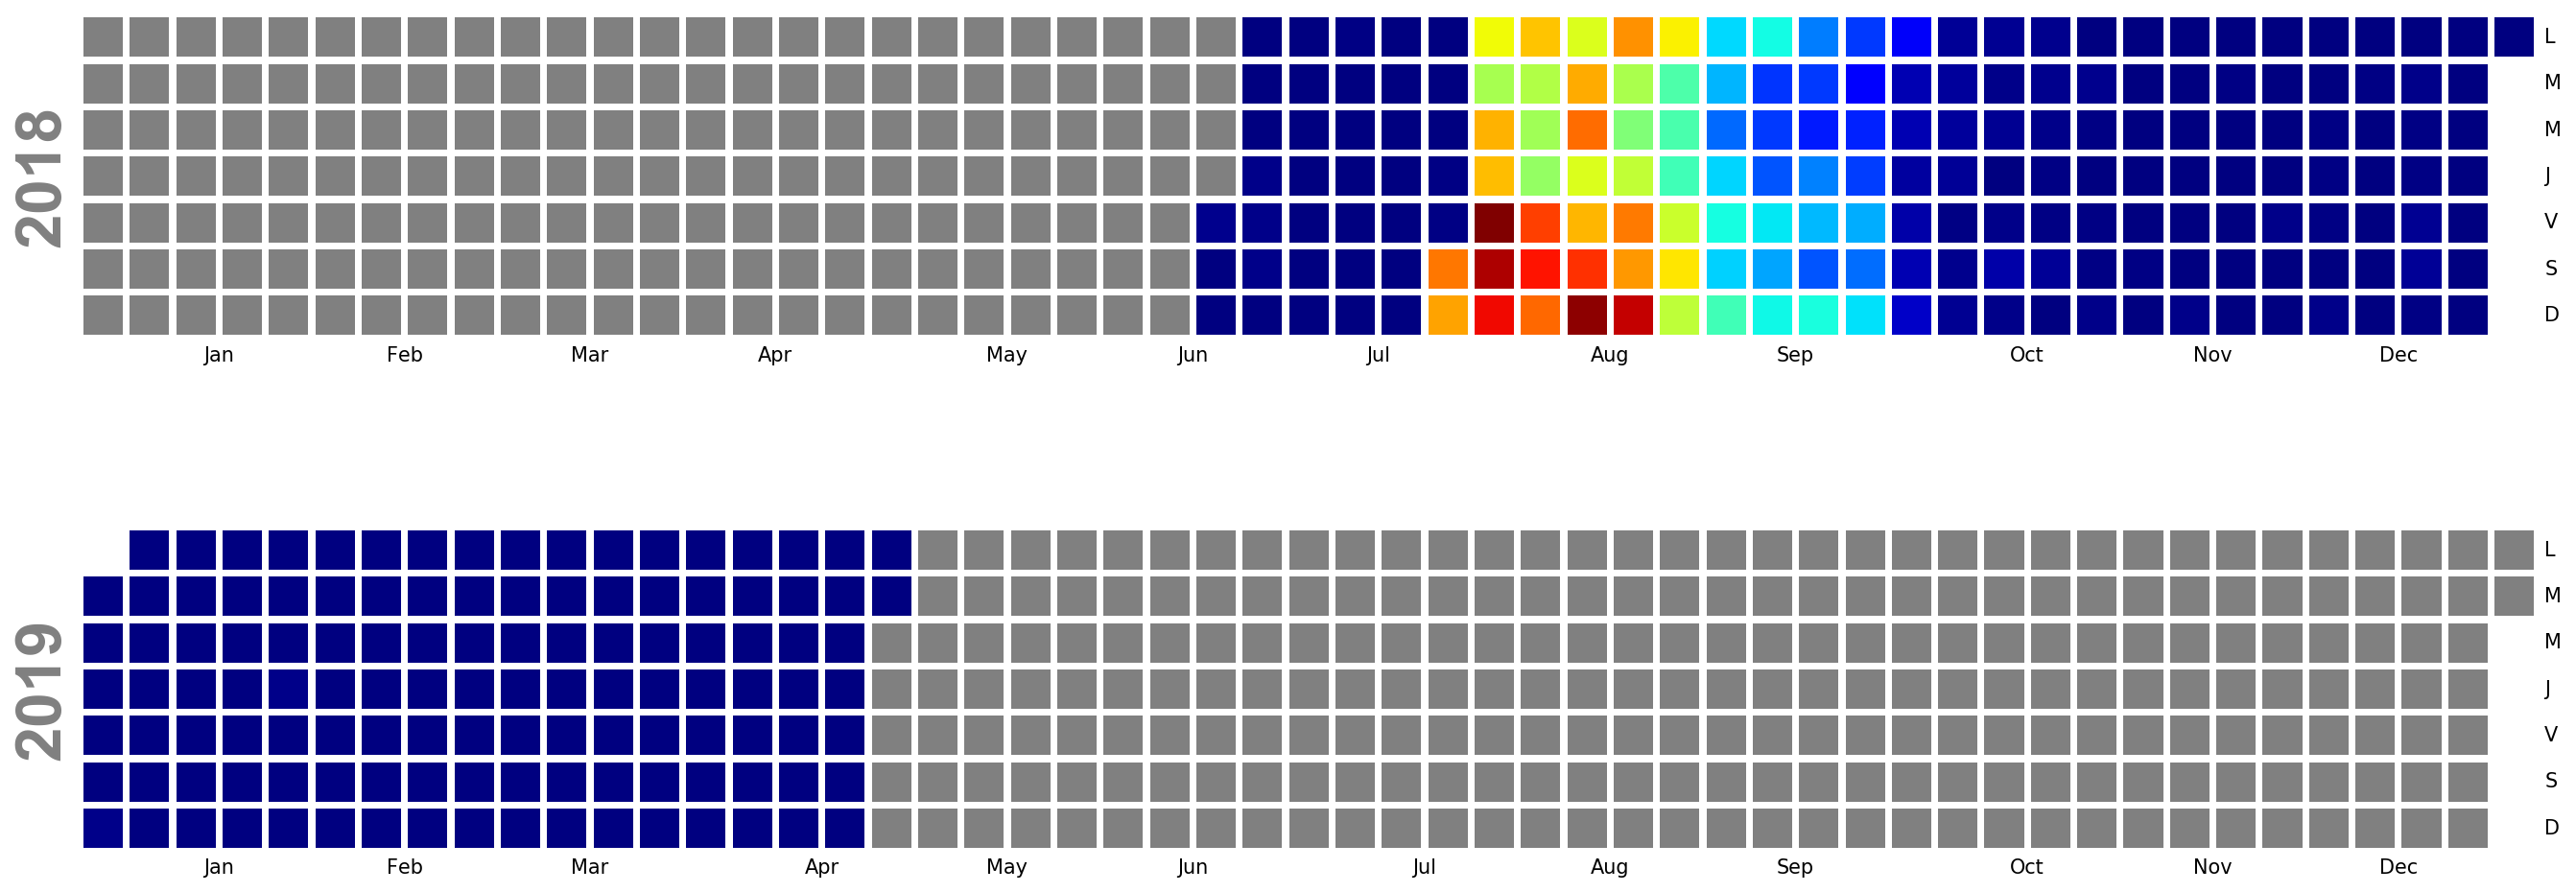

In [6]:
import calmap
s = df['departureDate']
ts = s.groupby(s.dt.floor('D')).size().reset_index(name='count')
souscriptions = pd.Series(data=ts['count'].tolist(), index=ts['departureDate'].tolist())
fig, ax = calmap.calendarplot(souscriptions, fillcolor='grey', monthticks=1, daylabels='LMMJVSD', 
                    fig_kws=dict(num=None,
                            figsize=(18,8),
                            dpi=150,
                            facecolor="w",
                            edgecolor="red",
                            ),
                    cmap='jet',
                    linewidth=3)
fig.savefig('flightDepartureDateHeatmap.png')
print("max : " + str(ts['count'].max()))
print("min : " + str(ts['count'].min()))

max : 7
min : 1


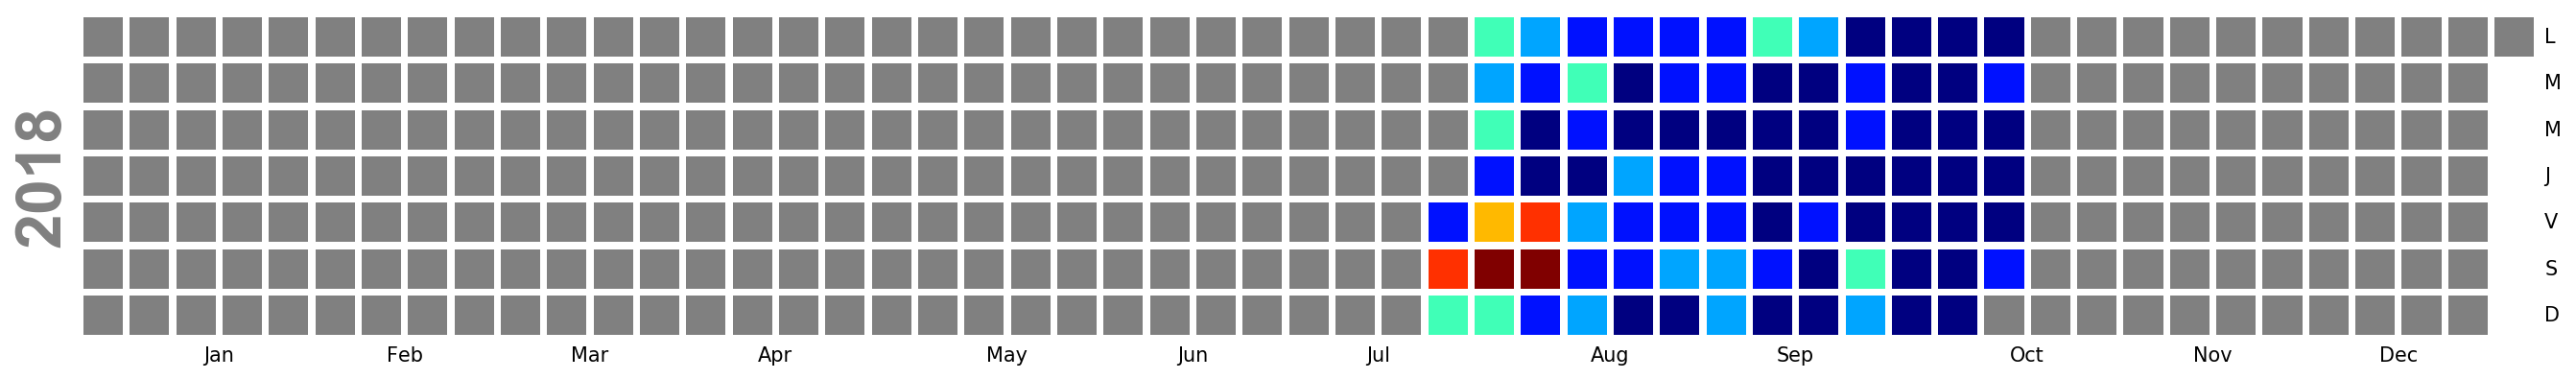

In [7]:
claim = df[df['eventStatus'] == 2]['timeStamp']
claimCount = claim.groupby(claim.dt.floor('D')).size().reset_index(name='count')

volRetard = pd.Series(data=claimCount['count'].tolist(), index=claimCount['timeStamp'].tolist())
fig, ax = calmap.calendarplot(volRetard, fillcolor='grey', monthticks=1, daylabels='LMMJVSD', 
                    fig_kws=dict(num=None,
                            figsize=(18,8),
                            dpi=150,
                            facecolor="w",
                            edgecolor="red",
                            ),
                    cmap='jet',
                    linewidth=3)
fig.savefig('claimHeatmap.png')
print("max : " + str(claimCount['count'].max()))
print("min : " + str(claimCount['count'].min()))

# Vol avec le plus de places assurées par fizzy

In [24]:
volUnique = df[df['eventName'] == 'InsuranceCreation'][['flightNo','departureDate']]
volUnique = volUnique.groupby(['flightNo','departureDate']).size().reset_index(name='size').sort_values(by='size', ascending=False)
a = volUnique[0:25]
a['detail'] = a.apply(lambda x: detailRoute(str(x['flightNo']), None) , axis=1)
print(a)

     flightNo departureDate  size                              detail
2911    AF256    2018-08-01    10    Vol AF256 : de Paris à Singapore
5534    AF702    2018-07-28    10      Vol AF702 : de Paris à Abidjan
5539    AF702    2018-08-04    10      Vol AF702 : de Paris à Abidjan
2132    AF165    2018-08-28     9      Vol AF165 : de Bangkok à Paris
5549    AF702    2018-08-17     9      Vol AF702 : de Paris à Abidjan
5550    AF702    2018-08-18     9      Vol AF702 : de Paris à Abidjan
4360    AF566    2018-07-28     9       Vol AF566 : de Paris à Beirut
2520    AF179    2018-08-26     8  Vol AF179 : de Mexico City à Paris
3593    AF374    2018-08-01     8    Vol AF374 : de Paris à Vancouver
2909    AF256    2018-07-30     8    Vol AF256 : de Paris à Singapore
5615    AF703    2018-09-02     8      Vol AF703 : de Abidjan à Paris
6364   AF7509    2018-08-26     8      Vol AF7509 : de Hyeres à Paris
2969    AF257    2018-08-21     8    Vol AF257 : de Singapore à Paris
5300   AF6235    201

C:\Users\a55397\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Répartition des niveaux de prime

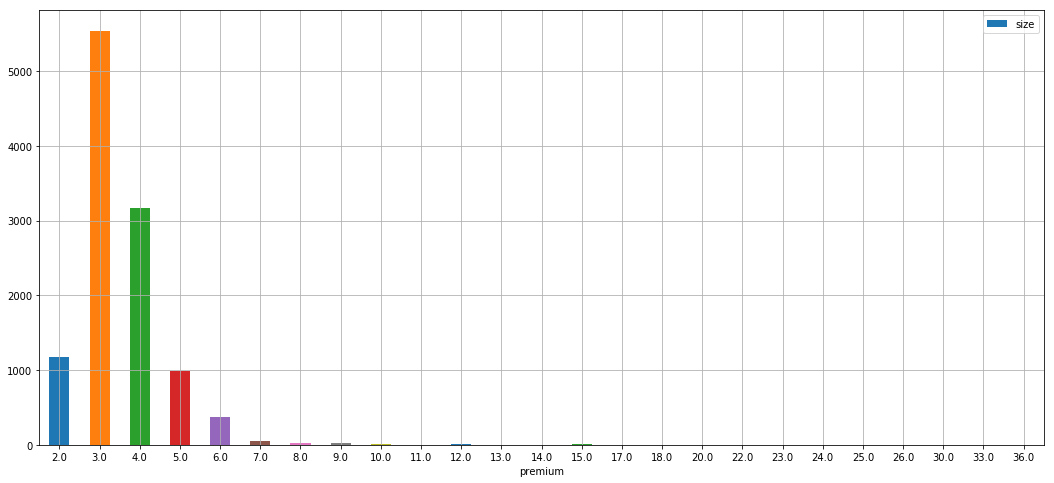

In [53]:
uniquePremium = df[df['eventName'] == 'InsuranceCreation']['premium'].groupby(df['premium']).size().reset_index(name='size').sort_values(by='premium', ascending=True)
uniquePremium.plot.bar(x='premium', y='size', figsize=(18,8), grid=True, rot=0)

# Répartition des garanties

C:\Users\a55397\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


        groupe   size
0     0€ - 49€      0
1    50€ - 99€     18
2  100€ - 149€  11260
3  150€ - 199€     46
4  200€ - 249€     27
5  250€ - 299€     10
6  300€ - 349€      6
7  350€ - 399€      3
8  400€ - 449€      0
9  450€ - 499€      5


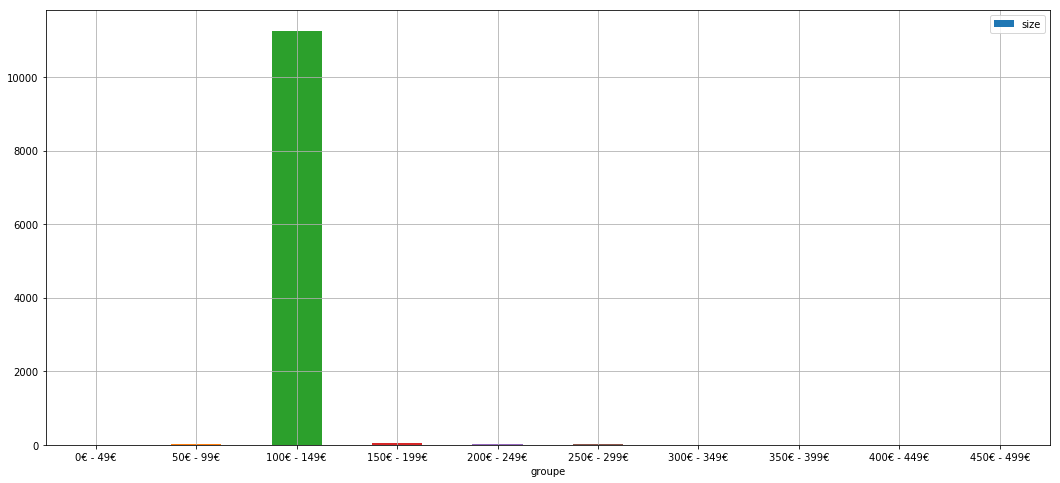

In [76]:
uniqueIndemnity = df[df['eventName'] == 'InsuranceCreation']
labels = ["{0}€ - {1}€".format(i, i + 49) for i in range(0, 500, 50)]
uniqueIndemnity['groupe'] = pd.cut(uniqueIndemnity['indemnity'], range(0,505,50), right=False, labels=labels)
uniqueIndemnity = uniqueIndemnity.groupby(uniqueIndemnity['groupe']).size().reset_index(name='size').sort_values(by='groupe', ascending=True)
uniqueIndemnity.plot.bar(x='groupe', y='size', figsize=(18,8), grid=True, rot=0)
print(uniqueIndemnity)